# Importing libraries

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

In [2]:
# Import Sionna components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, RadioMaterial, LambertianPattern
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, ApplyOFDMChannel
from sionna.nr import CarrierConfig, PUSCHDMRSConfig, TBConfig, PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import ebnodb2no, sim_ber

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

# Loading and setting scene properties

Loading scene

In [4]:
scene = load_scene("blender/scene.xml")
#scene = load_scene("blender/empty_scene.xml")

Creating custom materials

In [5]:
polycarbonate = RadioMaterial("polycarbonate",
                              relative_permittivity=3,
                              conductivity=0.001,
                              scattering_coefficient=0.3,
                              xpd_coefficient=0.1,
                              scattering_pattern=LambertianPattern())

cardboard  = RadioMaterial("cardboard",
                           relative_permittivity=2.3,
                           conductivity=0.001,
                           scattering_coefficient=0.3,
                           xpd_coefficient=0.1,
                           scattering_pattern=LambertianPattern())

plastic = RadioMaterial("plastic",
                        relative_permittivity=2.8,
                        conductivity=0.0001,
                        scattering_coefficient=0.3,
                        xpd_coefficient=0.1,
                        scattering_pattern=LambertianPattern())

ceramic  = RadioMaterial("ceramic",
                         relative_permittivity=6,
                         conductivity=0.0001,
                         scattering_coefficient=0.3,
                         xpd_coefficient=0.1,
                         scattering_pattern=LambertianPattern())

Selecting scene parts made from custom materials

In [6]:
Polycarbonate_parts = scene.get("Polycarbonate_parts")
Paper_boxes = scene.get("Paper_boxes") 
Plastic_parts = scene.get("Plastic_parts")  
Ceramic_parts = scene.get("Ceramic_parts")

Assigning custom materials to the scene

In [7]:
Polycarbonate_parts.radio_material = polycarbonate 
Paper_boxes.radio_material = cardboard 
Plastic_parts.radio_material = plastic 
Ceramic_parts.radio_material = ceramic

Setting scene parameters

In [8]:
scene.frequency = 60.48e9 # in Hz; implicitly updates RadioMaterials
scene.bandwidth = 512e6
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

# Configuration of TX and RX antenna

In [9]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1, #16
                             num_cols=1, #4
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern="tr38901",
                             polarization="H")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1, #16
                             num_cols=1, #16
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern="dipole",
                             polarization="H")

# Create transmitter
tx = Transmitter(name="tx",
                 color=tf.Variable((1, 0, 0), dtype=tf.float32),
                 position=tf.Variable([0.5,3,1], dtype=tf.float32), 
                 orientation=tf.Variable([0,0,0], dtype=tf.float32))

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              color=tf.Variable((1, 0, 0), dtype=tf.float32),
              position=tf.Variable([6.4,3,1], dtype=tf.float32),
              orientation=tf.Variable([0,0,0], dtype=tf.float32))

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver
rx.look_at(tx) # Receiver points towards transmitter 

# Compute propagation paths

In [10]:
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)  # Number of rays shot into directions defined
                                              # by a Fibonacci sphere , too few rays can
                                              # lead to missing paths

# PUSCH configuration

Carrier Config

In [11]:
carrier_config = CarrierConfig()
carrier_config.cyclic_prefix = "normal" # "extended"
carrier_config.num_subcarriers = 240
carrier_config.subcarrier_spacing = 120
carrier_config.show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 1.1067708333333334e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 3
n_cell_id : 1
n_size_grid : 4
n_start_grid : 0
num_slots_per_frame : 80
num_slots_per_subframe : 8
num_subcarriers : 240
num_symbols_per_slot : 14
slot_number : 0
sub_frame_duration : 0.001
subcarrier_spacing : 120
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08



DMRS Config

In [12]:
dmrs_config = PUSCHDMRSConfig(config_type=1)
dmrs_config.additional_position = 3 # number of pilot symbols
dmrs_config.type_a_position = 2 # index of first pilot symbols
dmrs_config.show()

PUSCH DMRS Configuration
additional_position : 3
allowed_dmrs_ports : [0, 1, 2, 3]
beta : 1.4142135623730951
cdm_groups : []
config_type : 1
deltas : []
dmrs_port_set : []
length : 1
n_id : None
n_scid : 0
num_cdm_groups_without_data : 2
type_a_position : 2
w_f : []
w_t : []



Transport block Config

In [13]:
tb_config = TBConfig(mcs_index=2)
tb_config.mcs_table = 4
tb_config.channel_type = "PUSCH"
tb_config.show()

Transport Block Configuration
channel_type : PUSCH
mcs_index : 2
mcs_table : 4
n_id : None
num_bits_per_symbol : 2
target_coderate : 0.4384765625
tb_scaling : 1.0



PUSCH Config

In [14]:
pusch_config = PUSCHConfig(carrier_config=carrier_config, pusch_dmrs_config=dmrs_config, tb_config=tb_config) 
pusch_config.mapping_type = "A"
pusch_config.n_size_bwp = 20 
pusch_config.show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 1.1067708333333334e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 3
n_cell_id : 1
n_size_grid : 4
n_start_grid : 0
num_slots_per_frame : 80
num_slots_per_subframe : 8
num_subcarriers : 240
num_symbols_per_slot : 14
slot_number : 0
sub_frame_duration : 0.001
subcarrier_spacing : 120
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08

PUSCH Configuration
dmrs_grid : shape (1, 240, 14)
dmrs_grid_precoded : shape ()
dmrs_mask : shape (240, 14)
dmrs_symbol_indices : [2, 5, 8, 11]
frequency_hopping : neither
l : [2, 5, 8, 11]
l_0 : 2
l_bar : [2, 5, 8, 11]
l_d : 14
l_prime : [0]
l_ref : 0
mapping_type : A
n : shape (60,)
n_rnti : 1
n_size_bwp : 20
n_start_bwp : 0
num_antenna_ports : 1
num_coded_bits : 4800
num_layers : 1
num_ov : 0
num_res_per_prb : 120
num_resource_blocks : 20
num_subcarriers : 240
precoding : non-codebook
precoding_matrix : None
symbol_allocation : [0, 14]
tb_size : 2088
tpmi : 0
transfo

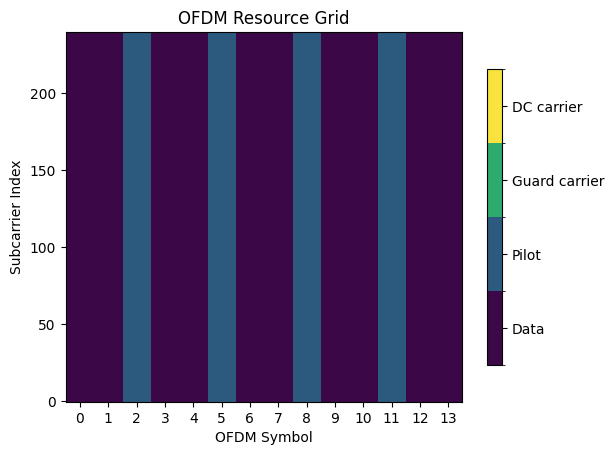

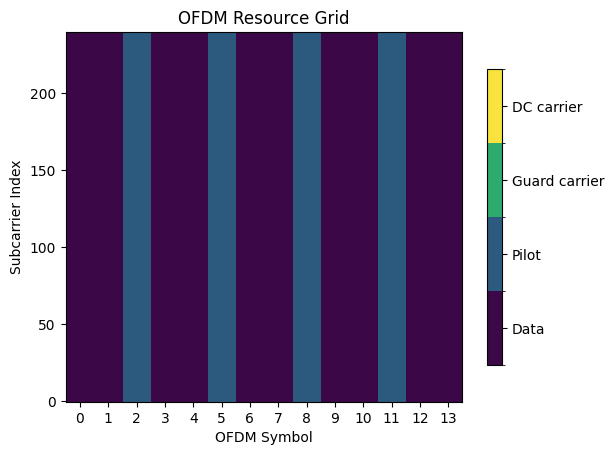

In [15]:
pusch_transmitter = PUSCHTransmitter(pusch_config)
pusch_transmitter.resource_grid.show()

# Model for BER simulations

In [16]:
# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True.
# See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
sn.config.xla_compat=False # not supported in CIRDataset

class Model(tf.keras.Model):
    """Simulate PUSCH transmissions over a CIR channel model.
                 Test,
                 subcarrier_spacing,
                 num_bits_per_symbol,
                 normalize,
                 paths
                 
    Parameters
    ----------
    Test : bool
        Determines if number of carriers will be 48 or 240

    subcarrier_spacing : int, one of [15e3,30e3,60e3,120e3,240e3,480e3,960e3]

    num_bits_per_symbol : int, one of [2,4,6,8,10]

    mcs_index : int, one of [2,4,6,8,10]
        2 = QPSK, 4 = 16QAM, 6 = 64QAM, 8 = 256QAM, 10 = 1024QAM

    normalize : bool
        Determines if path loss will be excluded 

    paths : tensor, paths
        Simulated paths.

    Input
    -----
    batch_size : int
        Number of simultaneously simulated slots

    ebno_db : float
        Signal-to-noise-ratio

    Output
    ------
    b : [batch_size, num_tx, tb_size], tf.float
        Transmitted information bits

    b_hat : [batch_size, num_tx, tb_size], tf.float
        Decoded information bits
    """
    def __init__(self,
                 Test,
                 subcarrier_spacing,
                 num_bits_per_symbol,
                 mcs_index,
                 normalize,
                 paths
                ):
        
        super().__init__()
        
        self.Test = Test
        self.subcarrier_spacing = subcarrier_spacing
        self.num_bits_per_symbol = num_bits_per_symbol
        self.mcs_index = mcs_index
        self.normalize = normalize

        self.paths = paths
        self.paths.normalize_delays = False
        self.a, self.tau = self.paths.cir()

        if self.Test == False:
            self.fft_size = 240
        else:
            self.fft_size = 48

        # Carrier Config 
        self.carrier_config = CarrierConfig()
        self.carrier_config.cyclic_prefix = "normal" 
        self.carrier_config.num_subcarriers = self.fft_size
        self.carrier_config.subcarrier_spacing = self.subcarrier_spacing/1000

        # DMRS Config 
        self.dmrs_config = PUSCHDMRSConfig(config_type=1)
        self.dmrs_config.additional_position = 3 
        self.dmrs_config.type_a_position = 2 
        
        # Transport block Config
        if num_bits_per_symbol == 2: # QPSK
            self.mcs_index = 2
        elif num_bits_per_symbol == 4: # 16QAM
            self.mcs_index = self.mcs_index
        elif num_bits_per_symbol == 6: # 64QAM
            self.mcs_index = 6
        elif num_bits_per_symbol == 8: # 256QAM
            self.mcs_index = 16
        elif num_bits_per_symbol == 10: # 1024QAM
            self.mcs_index = 24
        else:
            self.mcs_index = 3 # 16QAM

        self.tb_config = TBConfig(mcs_index=self.mcs_index)
        self.tb_config.mcs_table = 4
        self.tb_config.channel_type = "PUSCH"
        
        # PUSCH Config 
        self.pusch_config = PUSCHConfig(carrier_config=self.carrier_config, 
                                        pusch_dmrs_config=self.dmrs_config, 
                                        tb_config=self.tb_config) 
        self.pusch_config.mapping_type = "A"

        if self.Test == False:
            self.pusch_config.n_size_bwp = 20

        # Instantiate a PUSCHTransmitter from the PUSCHConfig
        self._pusch_transmitter = PUSCHTransmitter(self.pusch_config)

        # Create a PUSCHReceiver using the PUSCHTransmitter
        self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter)

        # Init channel layer
        self._channel = ApplyOFDMChannel(add_awgn=True)
    
    # XLA currently not supported by the CIRDataset function
    @tf.function(jit_compile=False)
    def call(self, batch_size, ebno_db):

        # Compute frequencies of subcarriers and center around carrier frequency
        frequencies = subcarrier_frequencies(self.fft_size, self.subcarrier_spacing)
            
        # Compute the frequency response of the channel at frequencies.
        h_freq = cir_to_ofdm_channel(frequencies,
                                     self.a,
                                     self.tau,
                                     normalize=self.normalize) # Non-normalized includes path-loss

        x, b = self._pusch_transmitter(batch_size)
        
        no = ebnodb2no(ebno_db,
                       self._pusch_transmitter._num_bits_per_symbol,
                       self._pusch_transmitter._target_coderate,
                       self._pusch_transmitter.resource_grid)

        y = self._channel([x, h_freq, no]) # Simulate channel output
        b_hat = self._pusch_receiver([y, no])
  
        return b, b_hat

# BER simulations

Settings for BER simulations

In [17]:
PUSCH_SIMS = {
    "num_bits_per_symbol" : [2,4,6,8,10],
    "subcarrier_spacing" : [15e3,120e3,480e3,960e3],
    "mcs_index" : [3,4,5],
    "ebno_db" : np.concatenate((np.linspace(0, 70, num=15), np.linspace(71, 100, num=30))),
    "ebno_db_norm" : np.linspace(-10, 30, num=81)
    }

Test = True
batch_size = 128

BER1 = []
BER2 = []
BER3 = []
BER4 = []
BER5 = []
BER6 = []

BLER1 = []
BLER2 = []
BLER3 = []
BLER4 = []
BLER5 = []
BLER6 = []

BERs for different modulations including path loss

In [18]:
for num_bits_per_symbol in PUSCH_SIMS["num_bits_per_symbol"]:
        
    model = Model(Test,
                  PUSCH_SIMS["subcarrier_spacing"][1], 
                  num_bits_per_symbol,
                  PUSCH_SIMS["mcs_index"][0],
                  False,
                  paths)

    ber, bler = sim_ber(model,
                        PUSCH_SIMS["ebno_db"],
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER1.append(list(ber.numpy()))
    BLER1.append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 5.0065e-01 | 1.0000e+00 |       55368 |      110592 |          256 |         256 |         8.6 |reached target block errors
      5.0 | 5.0160e-01 | 1.0000e+00 |       55473 |      110592 |          256 |         256 |         0.5 |reached target block errors
     10.0 | 5.0292e-01 | 1.0000e+00 |       55619 |      110592 |          256 |         256 |         0.5 |reached target block errors
     15.0 | 5.0195e-01 | 1.0000e+00 |       55512 |      110592 |          256 |         256 |         0.5 |reached target block errors
     20.0 | 4.9815e-01 | 1.0000e+00 |       55091 |      110592 |          256 |         256 |         0.5 |reached target block errors
     25.0 | 4.9958e-01 | 1.0000e+00 |       55250 |      110592 |

BERs for different modulations excluding path loss

In [19]:
for num_bits_per_symbol in PUSCH_SIMS["num_bits_per_symbol"]:
        
    model = Model(Test,
                  PUSCH_SIMS["subcarrier_spacing"][1], 
                  num_bits_per_symbol,
                  PUSCH_SIMS["mcs_index"][0],
                  True,
                  paths)

    ber, bler = sim_ber(model,
                        PUSCH_SIMS["ebno_db_norm"],
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER2.append(list(ber.numpy()))
    BLER2.append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.6758e-01 | 1.0000e+00 |       51711 |      110592 |          256 |         256 |         3.7 |reached target block errors
     -9.5 | 4.6382e-01 | 1.0000e+00 |       51295 |      110592 |          256 |         256 |         0.5 |reached target block errors
     -9.0 | 4.6240e-01 | 1.0000e+00 |       51138 |      110592 |          256 |         256 |         0.5 |reached target block errors
     -8.5 | 4.5852e-01 | 1.0000e+00 |       50709 |      110592 |          256 |         256 |         0.5 |reached target block errors
     -8.0 | 4.5209e-01 | 1.0000e+00 |       49998 |      110592 |          256 |         256 |         0.5 |reached target block errors
     -7.5 | 4.4844e-01 | 1.0000e+00 |       49594 |      110592 |

BERs for different subcarrier spacings including path loss

In [20]:
for subcarrier_spacing in PUSCH_SIMS["subcarrier_spacing"]:
        
    model = Model(Test,
                  subcarrier_spacing, 
                  PUSCH_SIMS["num_bits_per_symbol"][1],
                  PUSCH_SIMS["mcs_index"][0],
                  False,
                  paths)

    ber, bler = sim_ber(model,
                        PUSCH_SIMS["ebno_db"],
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER3.append(list(ber.numpy()))
    BLER3.append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.9931e-01 | 1.0000e+00 |       89988 |      180224 |          256 |         256 |         4.3 |reached target block errors
      5.0 | 5.0001e-01 | 1.0000e+00 |       90114 |      180224 |          256 |         256 |         0.7 |reached target block errors
     10.0 | 5.0006e-01 | 1.0000e+00 |       90122 |      180224 |          256 |         256 |         0.7 |reached target block errors
     15.0 | 4.9989e-01 | 1.0000e+00 |       90092 |      180224 |          256 |         256 |         0.7 |reached target block errors
     20.0 | 4.9908e-01 | 1.0000e+00 |       89947 |      180224 |          256 |         256 |         0.7 |reached target block errors
     25.0 | 4.9751e-01 | 1.0000e+00 |       89664 |      180224 |

BERs for different subcarrier spacings excluding path loss

In [21]:
for subcarrier_spacing in PUSCH_SIMS["subcarrier_spacing"]:
        
    model = Model(Test,
                  subcarrier_spacing, 
                  PUSCH_SIMS["num_bits_per_symbol"][1],
                  PUSCH_SIMS["mcs_index"][0],
                  True,
                  paths)

    ber, bler = sim_ber(model,
                        PUSCH_SIMS["ebno_db_norm"],
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER4.append(list(ber.numpy()))
    BLER4.append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.5554e-01 | 1.0000e+00 |       82099 |      180224 |          256 |         256 |         4.4 |reached target block errors
     -9.5 | 4.4846e-01 | 1.0000e+00 |       80824 |      180224 |          256 |         256 |         0.7 |reached target block errors
     -9.0 | 4.4415e-01 | 1.0000e+00 |       80047 |      180224 |          256 |         256 |         0.7 |reached target block errors
     -8.5 | 4.3891e-01 | 1.0000e+00 |       79103 |      180224 |          256 |         256 |         0.7 |reached target block errors
     -8.0 | 4.3344e-01 | 1.0000e+00 |       78116 |      180224 |          256 |         256 |         0.7 |reached target block errors
     -7.5 | 4.2759e-01 | 1.0000e+00 |       77062 |      180224 |

BERs for different subcarrier spacings including path loss

In [22]:
for mcs_index in PUSCH_SIMS["mcs_index"]:
        
    model = Model(Test,
                  PUSCH_SIMS["subcarrier_spacing"][1], 
                  PUSCH_SIMS["num_bits_per_symbol"][1],
                  mcs_index,
                  False,
                  paths)

    ber, bler = sim_ber(model,
                        PUSCH_SIMS["ebno_db"],
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER5.append(list(ber.numpy()))
    BLER5.append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.9934e-01 | 1.0000e+00 |       89993 |      180224 |          256 |         256 |         4.4 |reached target block errors
      5.0 | 5.0001e-01 | 1.0000e+00 |       90114 |      180224 |          256 |         256 |         0.7 |reached target block errors
     10.0 | 5.0005e-01 | 1.0000e+00 |       90121 |      180224 |          256 |         256 |         0.7 |reached target block errors
     15.0 | 4.9982e-01 | 1.0000e+00 |       90080 |      180224 |          256 |         256 |         0.7 |reached target block errors
     20.0 | 4.9905e-01 | 1.0000e+00 |       89941 |      180224 |          256 |         256 |         0.7 |reached target block errors
     25.0 | 4.9761e-01 | 1.0000e+00 |       89681 |      180224 |

BERs for different subcarrier spacings excluding path loss

In [23]:
for mcs_index in PUSCH_SIMS["mcs_index"]:
        
    model = Model(Test,
                  PUSCH_SIMS["subcarrier_spacing"][1], 
                  PUSCH_SIMS["num_bits_per_symbol"][1],
                  mcs_index,
                  True,
                  paths)

    ber, bler = sim_ber(model,
                        PUSCH_SIMS["ebno_db_norm"],
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER6.append(list(ber.numpy()))
    BLER6.append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.5644e-01 | 1.0000e+00 |       82261 |      180224 |          256 |         256 |         4.7 |reached target block errors
     -9.5 | 4.5112e-01 | 1.0000e+00 |       81303 |      180224 |          256 |         256 |         0.7 |reached target block errors
     -9.0 | 4.4706e-01 | 1.0000e+00 |       80571 |      180224 |          256 |         256 |         0.7 |reached target block errors
     -8.5 | 4.4171e-01 | 1.0000e+00 |       79607 |      180224 |          256 |         256 |         0.8 |reached target block errors
     -8.0 | 4.3552e-01 | 1.0000e+00 |       78491 |      180224 |          256 |         256 |         0.7 |reached target block errors
     -7.5 | 4.3077e-01 | 1.0000e+00 |       77635 |      180224 |

# BER plots

Loading ideal BER curves 

In [24]:
BER_modulation = np.load('data/BER_modulation.npy')
BER_coderate = np.load('data/BER_coderate.npy')

In [26]:
color = ["r", "g", "b", "orange", "darkviolet"]

BERs for different modulations including path loss

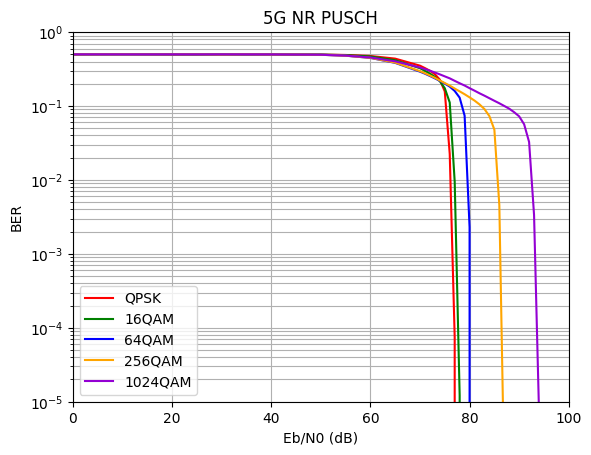

In [27]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS["ebno_db"][0], PUSCH_SIMS["ebno_db"][-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for num_bits_per_symbol in PUSCH_SIMS["num_bits_per_symbol"]:
    
    plt.semilogy(PUSCH_SIMS["ebno_db"], BER1[i], c=color[i])
    i += 1
    if num_bits_per_symbol == 2:
        legend.append("QPSK")
    else:
        legend.append(str(2 ** num_bits_per_symbol) + "QAM")
    
plt.legend(legend);

BERs for different modulations excluding path loss

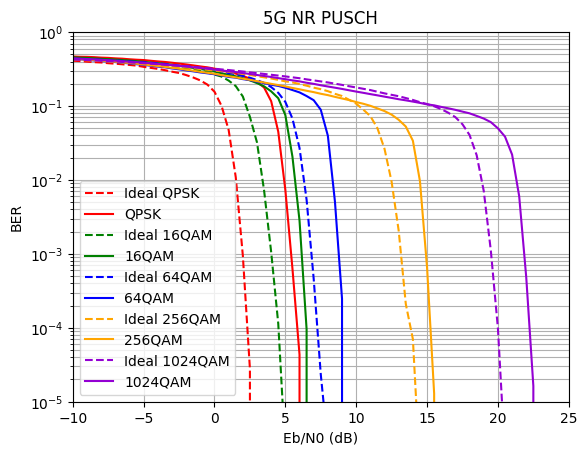

In [34]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS["ebno_db_norm"][0], PUSCH_SIMS["ebno_db_norm"][-11]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for num_bits_per_symbol in PUSCH_SIMS["num_bits_per_symbol"]:

    plt.semilogy(PUSCH_SIMS["ebno_db_norm"], BER_modulation[i], c=color[i], ls="--")
    plt.semilogy(PUSCH_SIMS["ebno_db_norm"], BER2[i], c=color[i])
    i += 1
    if num_bits_per_symbol == 2:
        legend.append("Ideal QPSK")
        legend.append("QPSK")
    else:
        legend.append("Ideal " + str(2 ** num_bits_per_symbol) + "QAM")
        legend.append(str(2 ** num_bits_per_symbol) + "QAM")
    
plt.legend(legend);

BERs for different subcarrier spacings including path loss

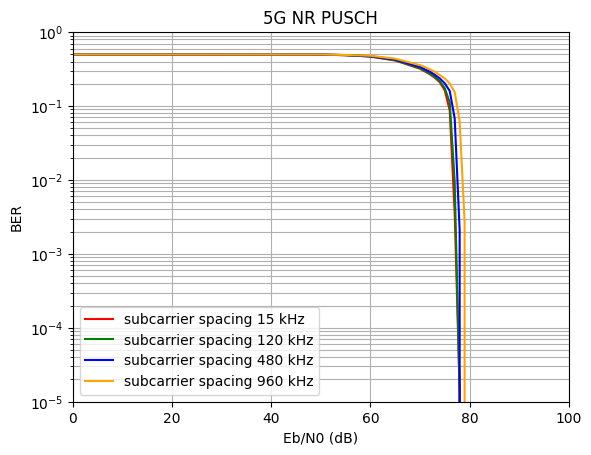

In [29]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS["ebno_db"][0], PUSCH_SIMS["ebno_db"][-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for subcarrier_spacing in PUSCH_SIMS["subcarrier_spacing"]:
    
    plt.semilogy(PUSCH_SIMS["ebno_db"], BER3[i], c=color[i])
    i += 1
    legend.append("subcarrier spacing " + str(int(subcarrier_spacing/1000)) + " kHz" )
   
plt.legend(legend);

BERs for different subcarrier spacings excluding path loss

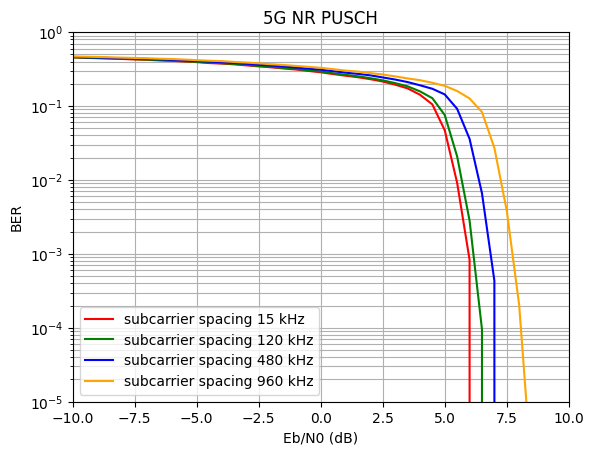

In [35]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS["ebno_db_norm"][0], PUSCH_SIMS["ebno_db_norm"][-41]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for subcarrier_spacing in PUSCH_SIMS["subcarrier_spacing"]:
    
    plt.semilogy(PUSCH_SIMS["ebno_db_norm"], BER4[i], c=color[i])
    i += 1
    legend.append("subcarrier spacing " + str(int(subcarrier_spacing/1000)) + " kHz" )
   
plt.legend(legend);

BERs for different subcarrier spacings including path loss

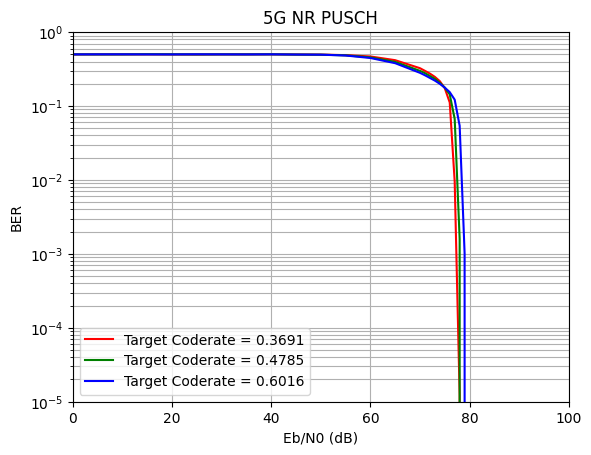

In [31]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS["ebno_db"][0], PUSCH_SIMS["ebno_db"][-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for mcs_index in PUSCH_SIMS["mcs_index"]:

    plt.semilogy(PUSCH_SIMS["ebno_db"], BER5[i], c=color[i])
    i += 1
    
    if mcs_index == 3:
        cr = 378/1024    
    elif mcs_index == 4:
        cr = 490/1024 
    elif mcs_index == 5:   
        cr = 616/1024  

    legend.append("Target Coderate = " + str('%.4f' % cr))
   
plt.legend(legend);

BERs for different subcarrier spacings excluding path loss

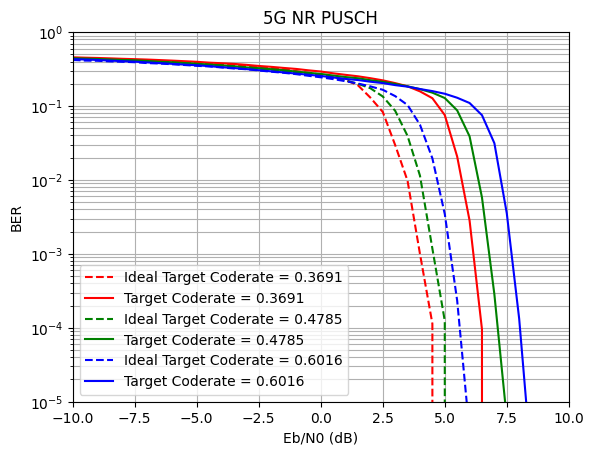

In [36]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS["ebno_db_norm"][0], PUSCH_SIMS["ebno_db_norm"][-41]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for mcs_index in PUSCH_SIMS["mcs_index"]:

    plt.semilogy(PUSCH_SIMS["ebno_db_norm"], BER_coderate[i], c=color[i], ls="--")
    plt.semilogy(PUSCH_SIMS["ebno_db_norm"], BER6[i], c=color[i])
   
    i += 1

    if mcs_index == 3:
        cr = 378/1024    
    elif mcs_index == 4:
        cr = 490/1024 
    elif mcs_index == 5:   
        cr = 616/1024  

    legend.append("Ideal Target Coderate = " + str('%.4f' % cr))
    legend.append("Target Coderate = " + str('%.4f' % cr))
   
plt.legend(legend);